<a href="https://colab.research.google.com/github/leo0622nycu/Essay/blob/main/MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
import pandas as pd
import numpy as np
import os
drive.mount('/content/drive')

Monthly_Revenue = pd.read_csv('/content/drive/MyDrive/CSV/Historical_Monthly_Revenue_November_2.csv')
ARIMA_TRAIN = pd.read_csv('/content/drive/MyDrive/CSV/ARIMA_TRAIN.csv')
ARIMA_TEST = pd.read_csv('/content/drive/MyDrive/CSV/ARIMA_TEST.csv')
residuals_all = pd.read_csv('/content/drive/MyDrive/CSV/residuals_all.csv')

Mounted at /content/drive


In [2]:
print(residuals_all.head())

   Unnamed: 0       revenue
0  2014-01-01  21244.248647
1  2014-02-01   9092.763251
2  2014-03-01 -14493.814235
3  2014-04-01  13116.201697
4  2014-05-01  14455.758282


In [8]:
data = Monthly_Revenue["revenue"]
train_data = data[:104]

test_data = data[102:]
print(train_data)
print(test_data)

0       51430
1       46829
2       49956
3       61887
4       60789
        ...  
99     172561
100    185705
101    175874
102    186763
103    218132
Name: revenue, Length: 104, dtype: int64
102    186763
103    218132
104    208248
105    210266
106    222706
107    192560
108    200051
109    163174
110    145408
111    147900
112    176537
113    156404
114    177616
115    188686
116    180430
117    243203
118    206026
119    176300
120    215785
121    181648
122    195211
123    236021
124    229620
125    207869
126    256953
127    250866
128    251873
129    314240
130    276058
Name: revenue, dtype: int64


In [9]:
from numpy import array

# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

# define input sequence
raw_seq = train_data
# choose a number of time steps
n_steps = 2
# split into samples
X, y = split_sequence(raw_seq, n_steps)
# summarize the data
for i in range(len(X)):
	print(X[i], y[i])

[51430 46829] 49956
[46829 49956] 61887
[49956 61887] 60789
[61887 60789] 60344
[60789 60344] 64925
[60344 64925] 69279
[64925 69279] 74846
[69279 74846] 80736
[74846 80736] 72275
[80736 72275] 69510
[72275 69510] 87120
[69510 87120] 62645
[87120 62645] 72269
[62645 72269] 75330
[72269 75330] 70155
[75330 70155] 59955
[70155 59955] 80953
[59955 80953] 67038
[80953 67038] 64514
[67038 64514] 81743
[64514 81743] 63428
[81743 63428] 58347
[63428 58347] 70855
[58347 70855] 59551
[70855 59551] 73089
[59551 73089] 66843
[73089 66843] 73576
[66843 73576] 81391
[73576 81391] 76392
[81391 76392] 94311
[76392 94311] 89703
[94311 89703] 91085
[89703 91085] 93030
[91085 93030] 78112
[93030 78112] 76616
[78112 76616] 71423
[76616 71423] 85875
[71423 85875] 56872
[85875 56872] 72796
[56872 72796] 84187
[72796 84187] 71611
[84187 71611] 91917
[71611 91917] 88579
[91917 88579] 94520
[88579 94520] 93153
[94520 93153] 89897
[93153 89897] 79741
[89897 79741] 64641
[79741 64641] 103697
[ 64641 103697] 818

In [10]:
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam

my_optimizer = Adam(learning_rate=1e-4)

from tensorflow.keras.callbacks import EarlyStopping

# 1. 定義 EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',          # 監控的指標 (這裡以 validation loss 為例)
    patience=20,                 # 耐心值: 若 val_loss 連續 20 個 epoch 不再改善，就停止訓練
    restore_best_weights=True    # 停止時，回復到最好的權重 (最低 val_loss)
)

from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,         # 每次 LR 降低的倍率
    patience=5,         # 在多少個 epoch 內沒有改善就降低 LR
    min_lr=1e-6         # 降到何種學習率就不再降
)

# define model
model = Sequential()
model.add(Dense(16, activation='relu', input_dim=n_steps))
model.add(Dense(8, activation='relu'))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss='mse',metrics=['mape'])
history = model.fit(X, y, validation_split=0.2, epochs=1000, batch_size=8, callbacks=[early_stopping], verbose=0)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


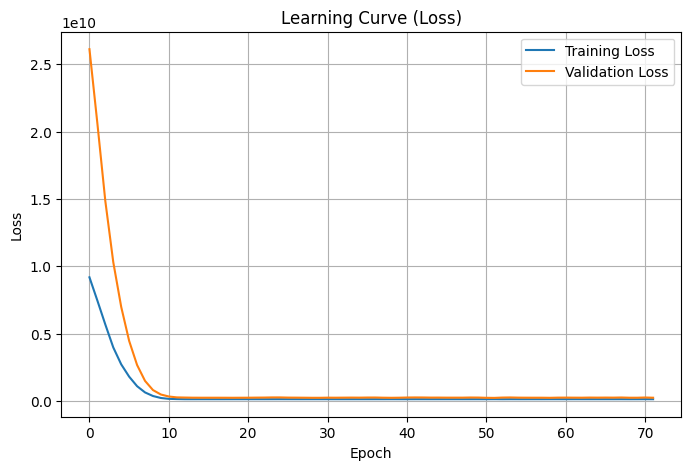

In [11]:
import matplotlib.pyplot as plt

epochs_range = range(len(history.history['loss']))

plt.figure(figsize=(8, 5))
plt.plot(epochs_range, history.history['loss'], label='Training Loss')
plt.plot(epochs_range, history.history['val_loss'], label='Validation Loss')
plt.title('Learning Curve (Loss)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [12]:
import matplotlib.pyplot as plt

# 假設 X, y 是你的訓練集 (由 split_sequence() 產生)
# 訓練完成後：
y_pred_train = model.predict(X)  # 模型在訓練集上的預測

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


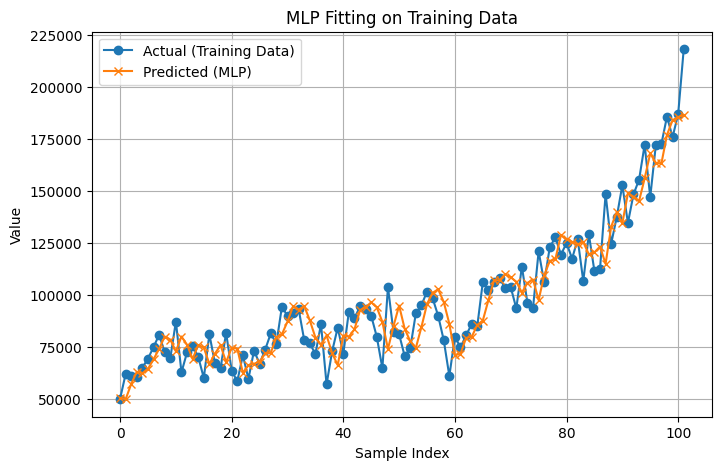

[ 50380.516  49723.715  57084.07   62969.457  62187.04   64333.234
  68946.87   74003.46   79891.62   78433.875  72755.57   79902.19
  75940.41   69074.63   75828.04   74619.1    66649.76   71649.07
  75774.66   67505.27   74575.15   74049.09   62447.113  66001.5
  66785.164  67726.27   71751.97   72041.43   79487.805  80935.9
  87138.76   94409.52   92843.055  94559.68   87646.     79419.92
  75930.14   80388.99   71922.23   66087.305  80364.96   79803.08
  83334.336  92622.33   94066.27   96336.77   93934.85   86945.234
  73898.98   84965.61   94782.54   83593.266  77579.29   74408.66
  84475.79   95544.516 100925.13  102607.586  96509.75   86042.02
  70919.39   71593.84   79206.75   79665.88   85436.914  87588.2
  97376.63  106882.4   106959.62  109862.97  108366.62  106283.82
 101031.23  105695.27  107312.414  97427.37  109392.01  116243.55
 117137.28  128666.1   126635.74  125446.89  124255.92  125346.195
 119471.54  120394.54  123183.23  114857.43  132751.78  139822.84
 134396.06

In [13]:
plt.figure(figsize=(8, 5))

# 實際值 (y) 本身就是 1D 的陣列
plt.plot(range(len(y)), y, marker='o', label='Actual (Training Data)')

# 預測值 (y_pred_train) 可能是 2D，先壓平成 1D
y_pred_train_1d = y_pred_train.flatten()
plt.plot(range(len(y_pred_train_1d)), y_pred_train_1d, marker='x', label='Predicted (MLP)')

plt.title('MLP Fitting on Training Data')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.grid(True)
plt.legend()
plt.show()

print(y_pred_train_1d)
print(y)

In [14]:
MLP_TRAIN_AC = train_data[2:]
MLP_TRAIN_PD = y_pred_train_1d
MLP_TRAIN_AC = MLP_TRAIN_AC.reset_index(drop=True)
print(MLP_TRAIN_AC)
print(MLP_TRAIN_PD)

0       49956
1       61887
2       60789
3       60344
4       64925
        ...  
97     172561
98     185705
99     175874
100    186763
101    218132
Name: revenue, Length: 102, dtype: int64
[ 50380.516  49723.715  57084.07   62969.457  62187.04   64333.234
  68946.87   74003.46   79891.62   78433.875  72755.57   79902.19
  75940.41   69074.63   75828.04   74619.1    66649.76   71649.07
  75774.66   67505.27   74575.15   74049.09   62447.113  66001.5
  66785.164  67726.27   71751.97   72041.43   79487.805  80935.9
  87138.76   94409.52   92843.055  94559.68   87646.     79419.92
  75930.14   80388.99   71922.23   66087.305  80364.96   79803.08
  83334.336  92622.33   94066.27   96336.77   93934.85   86945.234
  73898.98   84965.61   94782.54   83593.266  77579.29   74408.66
  84475.79   95544.516 100925.13  102607.586  96509.75   86042.02
  70919.39   71593.84   79206.75   79665.88   85436.914  87588.2
  97376.63  106882.4   106959.62  109862.97  108366.62  106283.82
 101031.23  10

In [15]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# 1. 計算 RMSE
rmse = np.sqrt(mean_squared_error(MLP_TRAIN_AC, MLP_TRAIN_PD))

# 2. 計算 MAE
mae = mean_absolute_error(MLP_TRAIN_AC, MLP_TRAIN_PD)

# 3. 計算 MAPE
mape = np.mean(np.abs((MLP_TRAIN_AC - MLP_TRAIN_PD) / MLP_TRAIN_AC)) * 100

# 4. 輸出結果
print(f"RMSE : {rmse:.2f}")
print(f"MAE : {mae:.2f}")
print(f"MAPE : {mape:.2f}%")

RMSE : 11888.72
MAE : 9526.07
MAPE : 10.57%


In [16]:
#開始預測

# 假設 n_steps 與訓練階段相同 (即 2)
n_steps = 2

# 先將 test_data 轉成 array 型態 (若原本是 Series 也可直接丟，但建議顯式轉換)
test_seq = test_data.values

# 使用相同的 split_sequence 函式做切分
X_test, y_test = split_sequence(test_seq, n_steps)
print(X_test)

[[186763 218132]
 [218132 208248]
 [208248 210266]
 [210266 222706]
 [222706 192560]
 [192560 200051]
 [200051 163174]
 [163174 145408]
 [145408 147900]
 [147900 176537]
 [176537 156404]
 [156404 177616]
 [177616 188686]
 [188686 180430]
 [180430 243203]
 [243203 206026]
 [206026 176300]
 [176300 215785]
 [215785 181648]
 [181648 195211]
 [195211 236021]
 [236021 229620]
 [229620 207869]
 [207869 256953]
 [256953 250866]
 [250866 251873]
 [251873 314240]]


In [17]:
# 使用訓練完成的模型進行預測
y_pred_test = model.predict(X_test)

# 如果要觀察預測值，可以壓平成 1D 後印出來
y_pred_test_1d = y_pred_test.flatten()
print("y_pred_test_1d:", y_pred_test_1d)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
y_pred_test_1d: [207188.88 218768.14 214908.06 222487.53 212757.97 201690.8  185937.62
 158169.   150630.75 165859.66 170640.1  171132.28 188222.28 189391.56
 215424.45 230090.06 195851.9  200222.5  203542.08 193548.75 220331.52
 238978.14 224293.81 237263.64 260638.27 258136.45 288849.6 ]


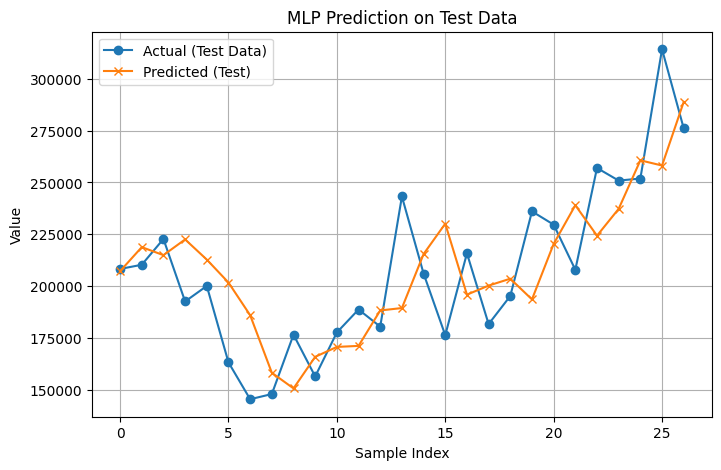

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))

# 實際值
plt.plot(range(len(y_test)), y_test, marker='o', label='Actual (Test Data)')

# 預測值 (1D)
plt.plot(range(len(y_pred_test_1d)), y_pred_test_1d, marker='x', label='Predicted (Test)')

plt.title('MLP Prediction on Test Data')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.grid(True)
plt.legend()
plt.show()

In [19]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np



# 1. 計算 RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred_test_1d))

# 2. 計算 MAE
mae = mean_absolute_error(y_test, y_pred_test_1d)

# 3. 計算 MAPE
mape = np.mean(np.abs((y_test - y_pred_test_1d) / y_test)) * 100

# 4. 輸出結果
print(f"RMSE : {rmse:.2f}")
print(f"MAE : {mae:.2f}")
print(f"MAPE : {mape:.2f}%")

RMSE : 27071.80
MAE : 21763.83
MAPE : 10.69%
